# Run DOLPHIN Model on 10X Colon
The processed PDAC dataset can be downloaded from this [link](https://outlook.office365.com/host/377c982d-9686-450e-9a7c-22aeaf1bc162/7211f19f-262a-42eb-a02e-289956491741)

In [1]:
from DOLPHIN.model import run_DOLPHIN
import numpy as np

/mnt/md0/kailu/anaconda3/envs/DOLPHIN/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#load datasets
graph_data = "./10x_colon/10x_colon_geometric.pt"
feature_data = "./10x_colon/10x_colon_FeatureCompHvg.h5ad"
## save the output adata, default is set to the current folder
output_path = './'

In [3]:
run_DOLPHIN("10x", graph_data, feature_data, output_path, seed_num=11)

/mnt/md1/kailu/DOLPHIN/DOLPHIN/model/train.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pg_celldata = torch.load(in_path_gp)


[epoch 000] training loss: 39881.0880
[epoch 001] training loss: 32405.7205
[epoch 002] training loss: 28672.9890
[epoch 003] training loss: 25492.6563
[epoch 004] training loss: 22758.5333
[epoch 005] training loss: 20404.1225
[epoch 006] training loss: 18372.2644
[epoch 007] training loss: 16613.3258
[epoch 008] training loss: 15087.5620
[epoch 009] training loss: 13760.6837
[epoch 010] training loss: 12602.1568
[epoch 011] training loss: 11593.4244
[epoch 012] training loss: 10706.0741
[epoch 013] training loss: 9927.1129
[epoch 014] training loss: 9243.9958
[epoch 015] training loss: 8640.7042
[epoch 016] training loss: 8106.9016
[epoch 017] training loss: 7633.6980
[epoch 018] training loss: 7213.6600
[epoch 019] training loss: 6839.3685
[epoch 020] training loss: 6506.4345
[epoch 021] training loss: 6209.0707
[epoch 022] training loss: 5943.6360
[epoch 023] training loss: 5705.0488
[epoch 024] training loss: 5491.7617
[epoch 025] training loss: 5300.2130
[epoch 026] training loss

In [4]:
import scanpy as sc
from sklearn.metrics import adjusted_rand_score

The result is saved at this [link](https://mcgill-my.sharepoint.com/my?id=%2Fpersonal%2Fkailu%5Fsong%5Fmail%5Fmcgill%5Fca%2FDocuments%2FDeepExonas%5Fgithub%5Fexample%2Fprocessed%5Fdataset)

In [5]:
adata = sc.read_h5ad("./DOLPHIN_Z.h5ad")

In [ ]:
sc.pp.neighbors(adata, use_rep="X_z")
sc.tl.umap(adata)
sc.tl.leiden(adata, 0.7, random_state=0)
print(len(set(adata.obs["leiden"])))
adjusted_rand_score(adata.obs["celltype"], adata.obs["leiden"])

7


0.4536361813033813

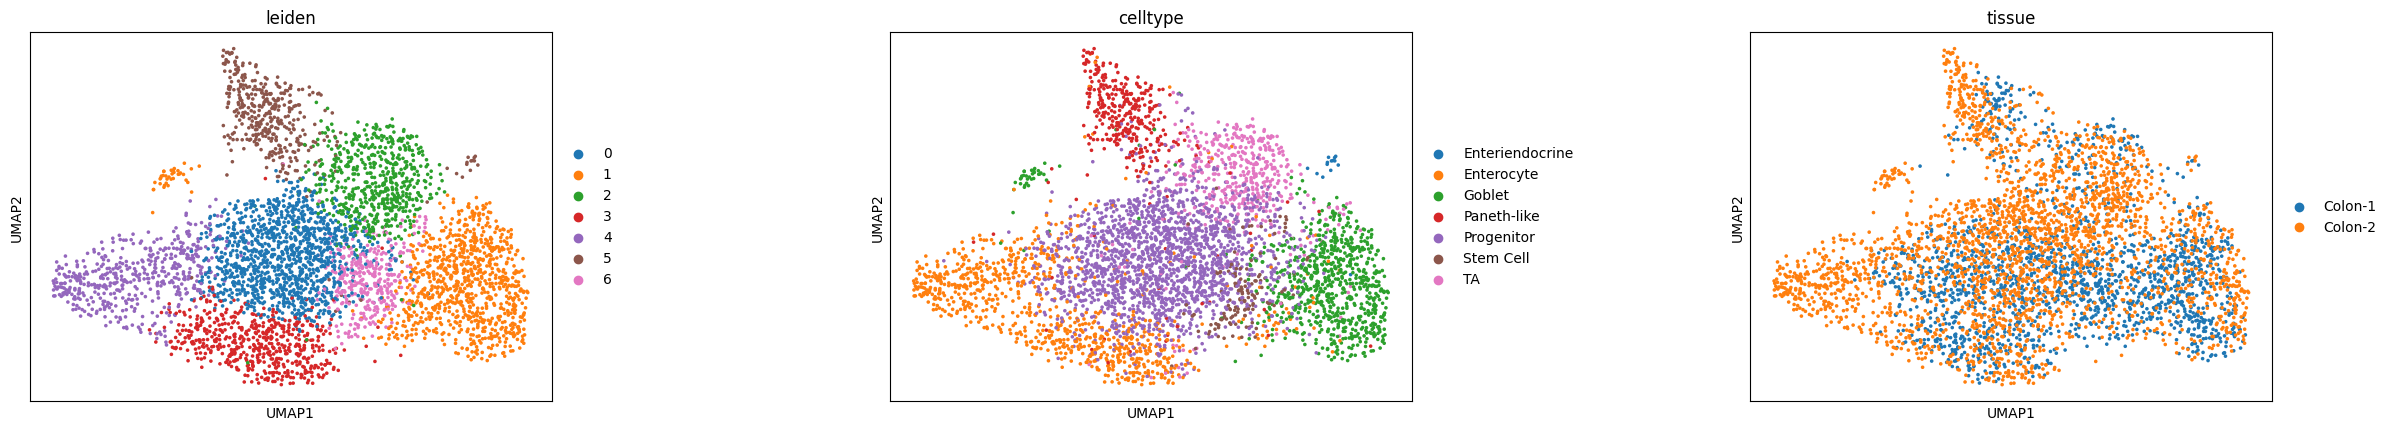

In [11]:
sc.pl.umap(adata, color=['leiden', "celltype", "tissue"], wspace=0.5)